# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.40KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

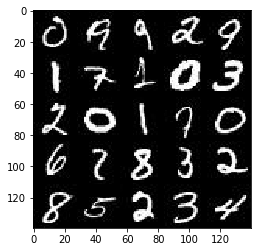

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

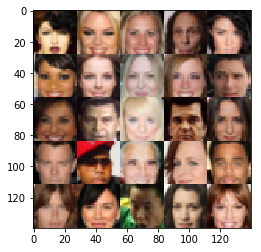

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')


    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        #input 28*28*3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.2 * x1, x1)
        #14*14*64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        #7*7*128
        
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return (logits, out)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(0.2 * bn1, bn1)
        
        x2 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        #14*14*128
        
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        #28*28*3
    
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return (d_loss, g_loss)
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    step = 0
        
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z})
                _ = sess.run(g_opt, feed_dict={input_real:batch_images, input_z:batch_z})
                
                if step % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                
                if step % 100 ==0:
                    show_generator_output(sess, 72, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0067... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0066... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0067... Generator Loss: 0.6929
Epoch 1/2... Discriminator Loss: 1.0066... Generator Loss: 0.6931


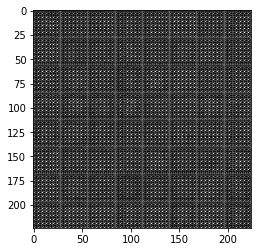

Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931


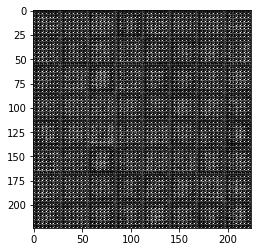

Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931


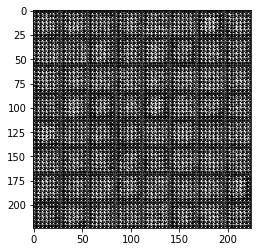

Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931


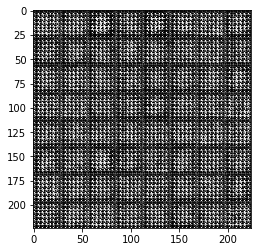

Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931


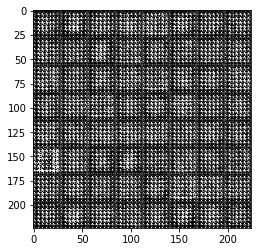

Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931


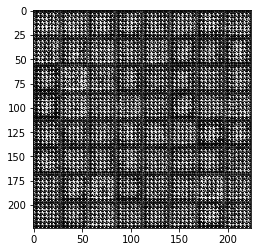

Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.0067... Generator Loss: 0.6929
Epoch 2/2... Discriminator Loss: 1.0497... Generator Loss: 0.6566
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931


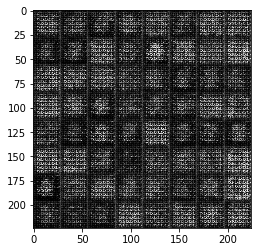

Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931


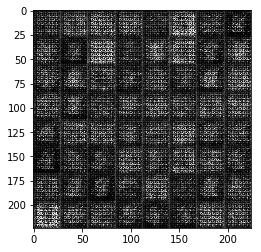

Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931


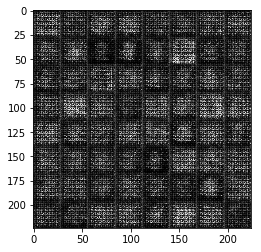

Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6931


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5721... Generator Loss: 0.3583
Epoch 1/1... Discriminator Loss: 1.5850... Generator Loss: 0.3708
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.4832
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.6411


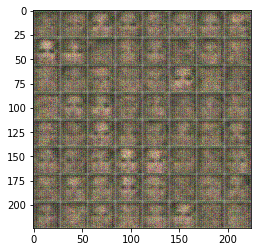

Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.6510


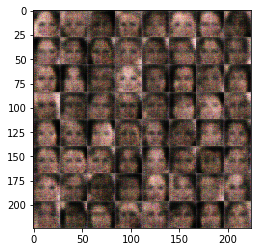

Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.6592


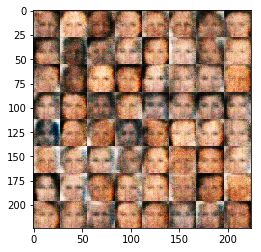

Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.6478


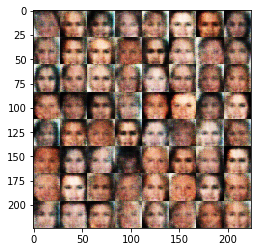

Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.6254


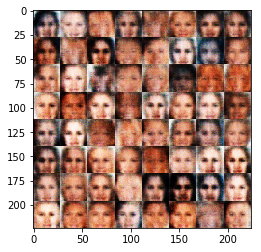

Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.6456


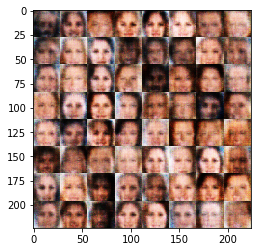

Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.6334


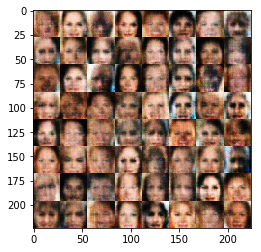

Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.6240


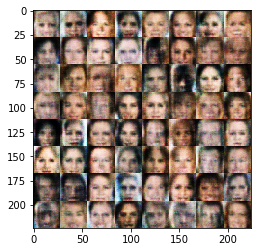

Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6336


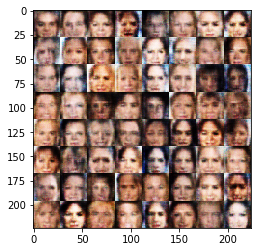

Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.6915


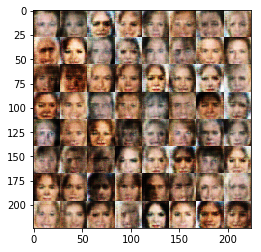

Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6928


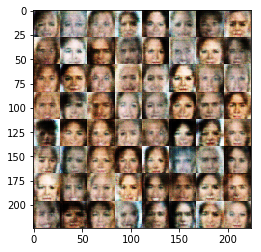

Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930


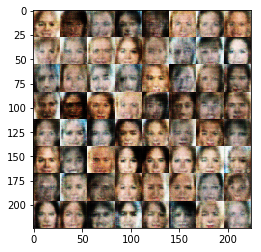

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930


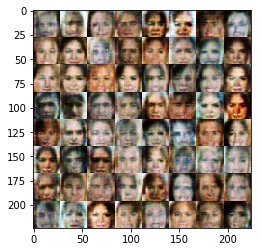

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930


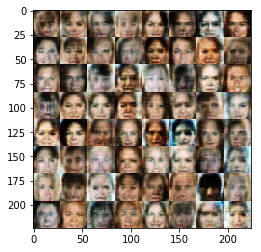

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930


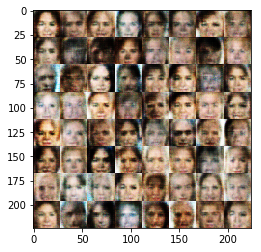

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6930


In [17]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.